# E-commerce Sales Analytics & Customer Segmentation

**Date:** December 2018  
**Dataset:** UCI Online Retail Dataset

---

## Project Overview

This project analyzes transactional data from a UK-based online retail company to:

1. **Explore sales trends** and identify seasonal patterns
2. **Segment customers** using RFM (Recency, Frequency, Monetary) analysis
3. **Build a demand forecasting model** for inventory optimization
4. **Generate actionable business insights** for marketing and operations

### Business Questions Addressed:
- What are the peak sales periods and best-selling products?
- Who are our most valuable customers?
- How can we predict future demand to optimize inventory?
- Which customer segments should marketing prioritize?

---

## 1. Setup & Data Loading

In [9]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('Libraries loaded successfully!')

Libraries loaded successfully!


In [10]:
# Load the UCI Online Retail dataset
# Dataset source: https://archive.ics.uci.edu/ml/datasets/online+retail

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

# Load data
print('Loading dataset... (this may take a moment)')
df = pd.read_excel(url)
print(f'Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns')

Loading dataset... (this may take a moment)
Dataset loaded: 541,909 rows, 8 columns


In [11]:
# First look at the data
print('=== Dataset Info ===')
print(f'Shape: {df.shape}')
print(f'\nColumn Types:')
print(df.dtypes)
print(f'\nFirst 5 rows:')
df.head()

=== Dataset Info ===
Shape: (541909, 8)

Column Types:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

First 5 rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


In [12]:
# Check for missing values
print('=== Missing Values ===')
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0])

=== Missing Values ===
             Missing Count  Percentage
Description           1454        0.27
CustomerID          135080       24.93


## 2. Data Cleaning & Preprocessing

In [13]:
# Create a copy for cleaning
data = df.copy()

# Remove rows with missing CustomerID (can't do customer analysis without it)
print(f'Rows before cleaning: {len(data):,}')
data = data.dropna(subset=['CustomerID'])
print(f'Rows after removing missing CustomerID: {len(data):,}')

# Remove cancelled orders (InvoiceNo starting with 'C')
data = data[~data['InvoiceNo'].astype(str).str.startswith('C')]
print(f'Rows after removing cancellations: {len(data):,}')

# Remove negative quantities and prices
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]
print(f'Rows after removing invalid quantities/prices: {len(data):,}')

# Convert CustomerID to integer
data['CustomerID'] = data['CustomerID'].astype(int)

# Create Revenue column
data['Revenue'] = data['Quantity'] * data['UnitPrice']

# Extract date features
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Date'] = data['InvoiceDate'].dt.date
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek
data['Hour'] = data['InvoiceDate'].dt.hour

print(f'\nFinal cleaned dataset: {len(data):,} rows')
data.head()

Rows before cleaning: 541,909
Rows after removing missing CustomerID: 406,829
Rows after removing cancellations: 397,924
Rows after removing invalid quantities/prices: 397,884

Final cleaned dataset: 397,884 rows


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Date,Year,Month,DayOfWeek,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010,12,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010,12,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010,12,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010,12,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010,12,2,8


In [14]:
# Summary statistics
print('=== Summary Statistics ===')
print(f"Date Range: {data['InvoiceDate'].min()} to {data['InvoiceDate'].max()}")
print(f"Total Transactions: {data['InvoiceNo'].nunique():,}")
print(f"Total Customers: {data['CustomerID'].nunique():,}")
print(f"Total Products: {data['StockCode'].nunique():,}")
print(f"Total Revenue: ${data['Revenue'].sum():,.2f}")
print(f"Countries: {data['Country'].nunique()}")

=== Summary Statistics ===
Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Total Transactions: 18,532
Total Customers: 4,338
Total Products: 3,665
Total Revenue: $8,911,407.90
Countries: 37


## 3. Exploratory Data Analysis (EDA)

### 3.1 Revenue Analysis

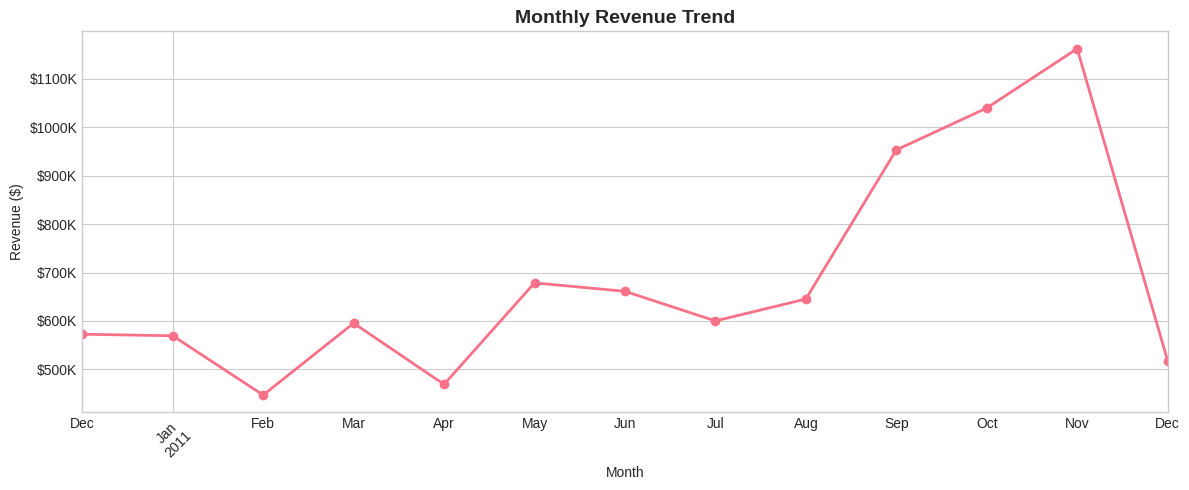


=== Key Insight ===
Peak revenue month: 2011-11 ($1,161,817.38)
Average monthly revenue: $685,492.92


In [15]:
# Monthly Revenue Trend
monthly_revenue = data.groupby([data['InvoiceDate'].dt.to_period('M')])['Revenue'].sum()

fig, ax = plt.subplots(figsize=(12, 5))
monthly_revenue.plot(kind='line', marker='o', ax=ax, linewidth=2, markersize=6)
ax.set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Revenue ($)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('monthly_revenue_trend.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n=== Key Insight ===')
print(f"Peak revenue month: {monthly_revenue.idxmax()} (${monthly_revenue.max():,.2f})")
print(f"Average monthly revenue: ${monthly_revenue.mean():,.2f}")

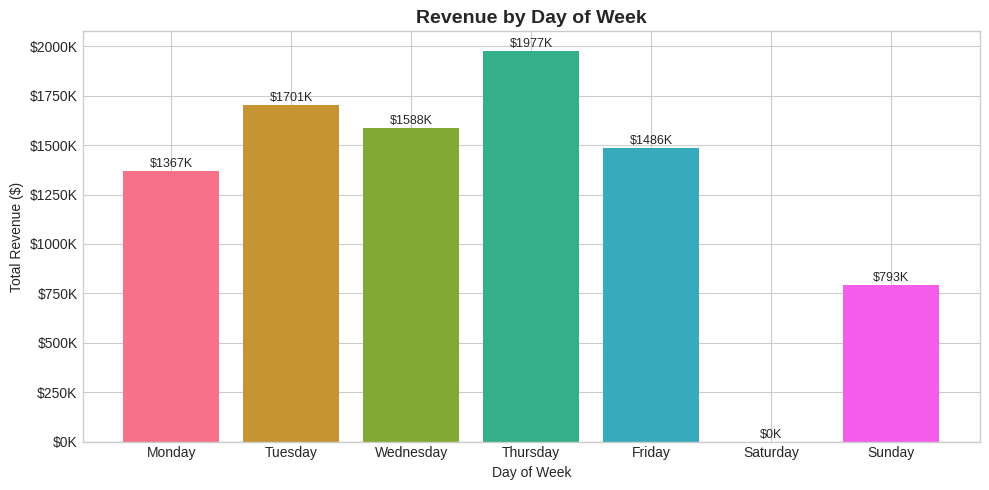


=== Key Insight ===
Highest revenue day: Thursday
Note: Saturday shows significantly lower sales - potential for weekend promotions


In [16]:
# Revenue by Day of Week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_revenue = data.groupby('DayOfWeek')['Revenue'].sum()

# Reindex daily_revenue to include all days of the week (0-6) and fill missing with 0
daily_revenue = daily_revenue.reindex(range(7), fill_value=0)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(day_names, daily_revenue.values, color=sns.color_palette('husl', 7))
ax.set_title('Revenue by Day of Week', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Total Revenue ($)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add value labels
for bar, val in zip(bars, daily_revenue.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000,
            f'${val/1000:.0f}K', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('revenue_by_day.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n=== Key Insight ===')
print(f"Highest revenue day: {day_names[daily_revenue.idxmax()]}")
print(f"Note: Saturday shows significantly lower sales - potential for weekend promotions")

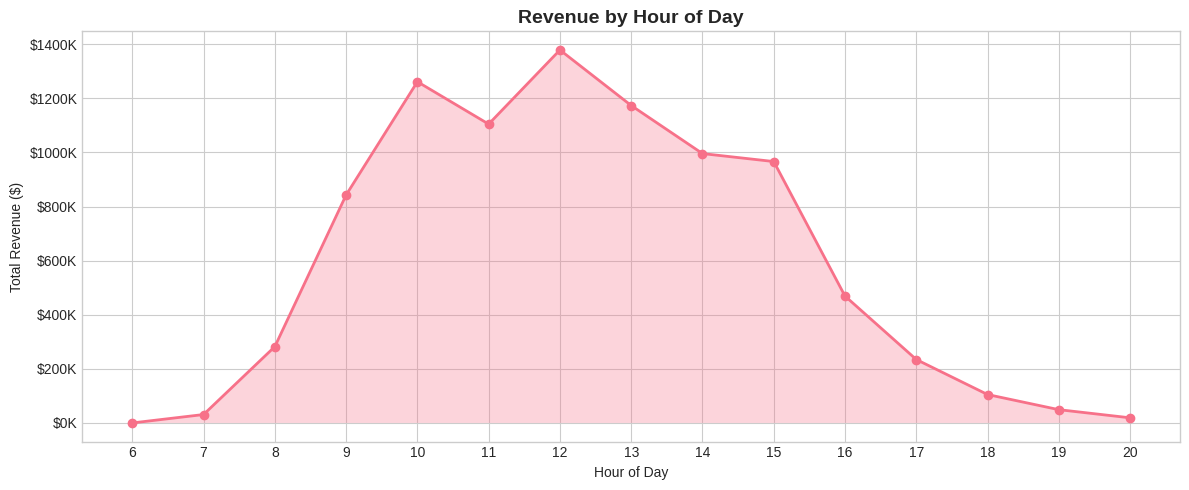


=== Key Insight ===
Peak shopping hours: 10 AM - 3 PM
Recommendation: Schedule marketing emails and promotions for morning hours


In [17]:
# Revenue by Hour
hourly_revenue = data.groupby('Hour')['Revenue'].sum()

fig, ax = plt.subplots(figsize=(12, 5))
ax.fill_between(hourly_revenue.index, hourly_revenue.values, alpha=0.3)
ax.plot(hourly_revenue.index, hourly_revenue.values, linewidth=2, marker='o')
ax.set_title('Revenue by Hour of Day', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Total Revenue ($)')
ax.set_xticks(range(6, 21))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
plt.tight_layout()
plt.savefig('revenue_by_hour.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n=== Key Insight ===')
print(f"Peak shopping hours: 10 AM - 3 PM")
print(f"Recommendation: Schedule marketing emails and promotions for morning hours")

### 3.2 Product Analysis

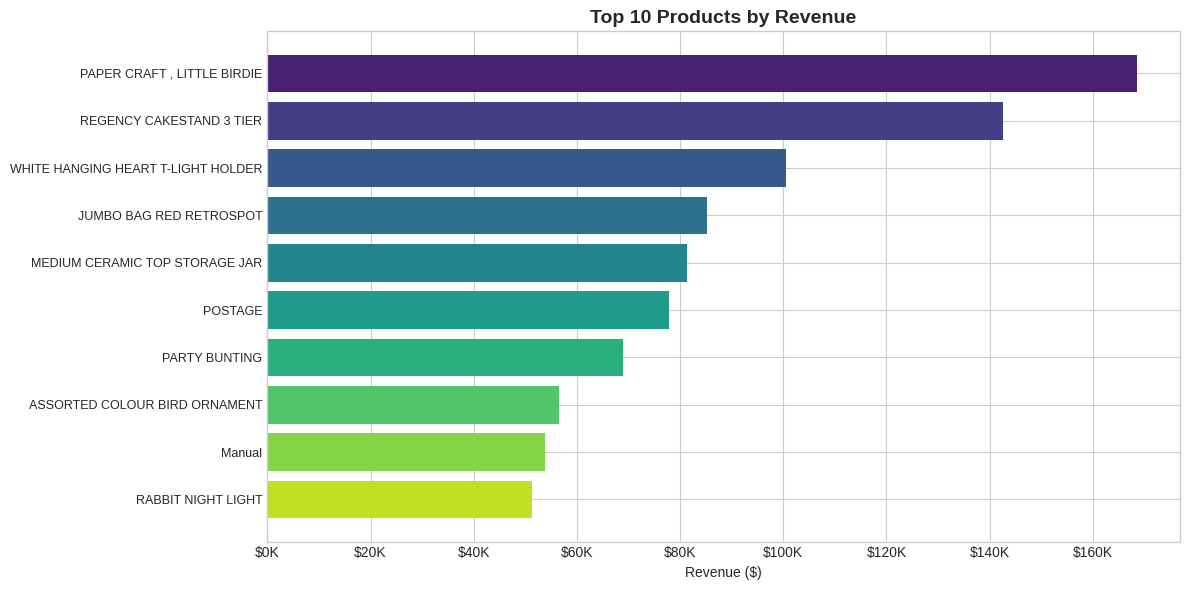


=== Top 5 Products ===
1. PAPER CRAFT , LITTLE BIRDIE: $168,469.60
2. REGENCY CAKESTAND 3 TIER: $142,592.95
3. WHITE HANGING HEART T-LIGHT HOLDER: $100,448.15
4. JUMBO BAG RED RETROSPOT: $85,220.78
5. MEDIUM CERAMIC TOP STORAGE JAR: $81,416.73


In [18]:
# Top 10 Products by Revenue
product_revenue = data.groupby(['StockCode', 'Description'])['Revenue'].sum().sort_values(ascending=False)
top_10_products = product_revenue.head(10).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(range(10), top_10_products['Revenue'].values, color=sns.color_palette('viridis', 10))
ax.set_yticks(range(10))
ax.set_yticklabels([desc[:40] + '...' if len(str(desc)) > 40 else desc
                    for desc in top_10_products['Description']], fontsize=9)
ax.set_title('Top 10 Products by Revenue', fontsize=14, fontweight='bold')
ax.set_xlabel('Revenue ($)')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('top_10_products.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n=== Top 5 Products ===')
for i, row in top_10_products.head(5).iterrows():
    print(f"{i+1}. {row['Description'][:50]}: ${row['Revenue']:,.2f}")

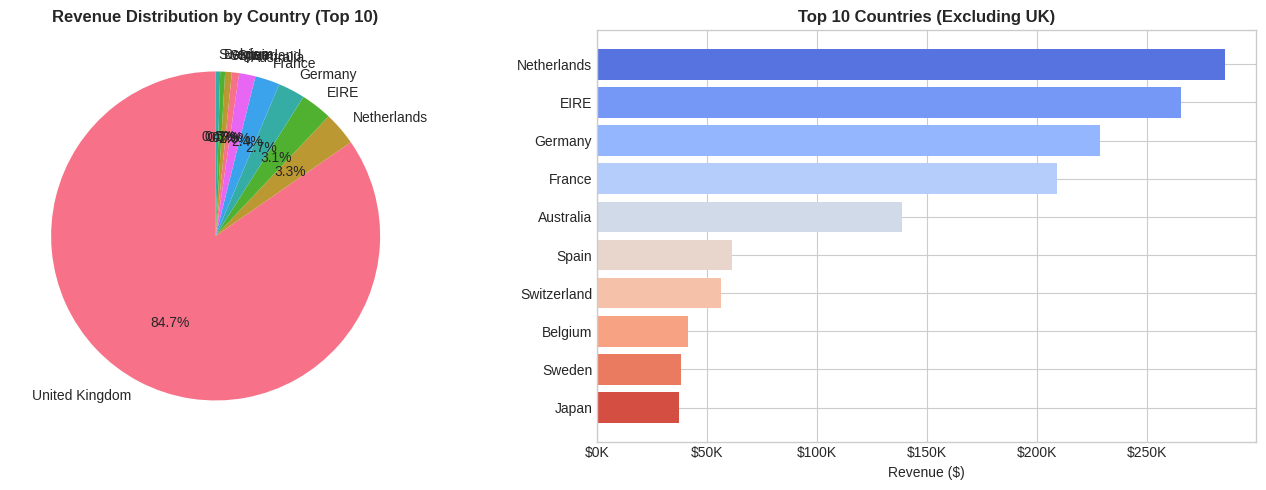


=== Key Insight ===
UK accounts for 82.0% of revenue
Top international markets: ['Netherlands', 'EIRE', 'Germany']


In [19]:
# Top 10 Countries by Revenue (excluding UK)
country_revenue = data.groupby('Country')['Revenue'].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All countries
top_countries = country_revenue.head(10)
axes[0].pie(top_countries.values, labels=top_countries.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Revenue Distribution by Country (Top 10)', fontweight='bold')

# Excluding UK
non_uk = country_revenue[country_revenue.index != 'United Kingdom'].head(10)
axes[1].barh(range(len(non_uk)), non_uk.values, color=sns.color_palette('coolwarm', len(non_uk)))
axes[1].set_yticks(range(len(non_uk)))
axes[1].set_yticklabels(non_uk.index)
axes[1].set_title('Top 10 Countries (Excluding UK)', fontweight='bold')
axes[1].set_xlabel('Revenue ($)')
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('revenue_by_country.png', dpi=150, bbox_inches='tight')
plt.show()

uk_pct = (country_revenue['United Kingdom'] / country_revenue.sum() * 100)
print(f'\n=== Key Insight ===')
print(f'UK accounts for {uk_pct:.1f}% of revenue')
print(f'Top international markets: {list(non_uk.head(3).index)}')

## 4. Customer Segmentation (RFM Analysis)

In [20]:
# Calculate RFM metrics
# Reference date = day after last transaction
reference_date = data['InvoiceDate'].max() + timedelta(days=1)

rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'Revenue': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print('=== RFM Summary Statistics ===')
print(rfm[['Recency', 'Frequency', 'Monetary']].describe().round(2))
rfm.head(10)

=== RFM Summary Statistics ===
       Recency  Frequency  Monetary
count  4338.00    4338.00   4338.00
mean     92.54       4.27   2054.27
std     100.01       7.70   8989.23
min       1.00       1.00      3.75
25%      18.00       1.00    307.41
50%      51.00       2.00    674.48
75%     142.00       5.00   1661.74
max     374.00     209.00 280206.02


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40
5,12352,36,8,2506.04
6,12353,204,1,89.00
7,12354,232,1,1079.40
8,12355,214,1,459.40
9,12356,23,3,2811.43


In [21]:
# RFM Score Calculation (1-5 scale)
# Recency: lower is better (more recent)
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1])

# Frequency: higher is better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])

# Monetary: higher is better
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=[1, 2, 3, 4, 5])

# Combined RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Total'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)

rfm.head(10)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Total
0,12346,326,1,77183.60,1,1,5,115,7
1,12347,2,7,4310.00,5,5,5,555,15
2,12348,75,4,1797.24,2,4,4,244,10
3,12349,19,1,1757.55,4,1,4,414,9
4,12350,310,1,334.40,1,1,2,112,4
5,12352,36,8,2506.04,3,5,5,355,13
6,12353,204,1,89.00,1,1,1,111,3
7,12354,232,1,1079.40,1,1,4,114,6
8,12355,214,1,459.40,1,1,2,112,4
9,12356,23,3,2811.43,4,3,5,435,12


In [22]:
# Customer Segmentation based on RFM
def segment_customer(row):
    r, f, m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])

    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyal Customers'
    elif r >= 4 and f <= 2:
        return 'New Customers'
    elif r >= 3 and f >= 3 and m <= 2:
        return 'Potential Loyalists'
    elif r <= 2 and f >= 3 and m >= 3:
        return 'At Risk'
    elif r <= 2 and f <= 2 and m >= 3:
        return 'Cant Lose Them'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Lost'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# Segment summary
segment_summary = rfm.groupby('Segment').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum']
}).round(2)

segment_summary.columns = ['Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue']
segment_summary['Pct_Customers'] = (segment_summary['Count'] / segment_summary['Count'].sum() * 100).round(1)
segment_summary['Pct_Revenue'] = (segment_summary['Total_Revenue'] / segment_summary['Total_Revenue'].sum() * 100).round(1)
segment_summary = segment_summary.sort_values('Total_Revenue', ascending=False)

print('=== Customer Segments ===')
segment_summary

=== Customer Segments ===


,Count,Avg_Recency,Avg_Frequency,Avg_Monetary,Total_Revenue,Pct_Customers,Pct_Revenue
Segment,,,,,,,
Champions,962,12.86,11.08,6038.82,5809341.07,22.20,65.20
Loyal Customers,758,35.69,4.13,1842.60,1396691.42,17.50,15.70
At Risk,454,141.63,3.81,1634.69,742149.95,10.50,8.30
Cant Lose Them,241,181.63,1.30,1367.79,329637.70,5.60,3.70
Others,540,97.71,1.61,407.80,220214.19,12.40,2.50
Lost,824,228.50,1.04,230.30,189770.87,19.00,2.10
New Customers,319,18.52,1.24,458.20,146166.57,7.40,1.60
Potential Loyalists,240,29.05,2.42,322.65,77436.13,5.50,0.90


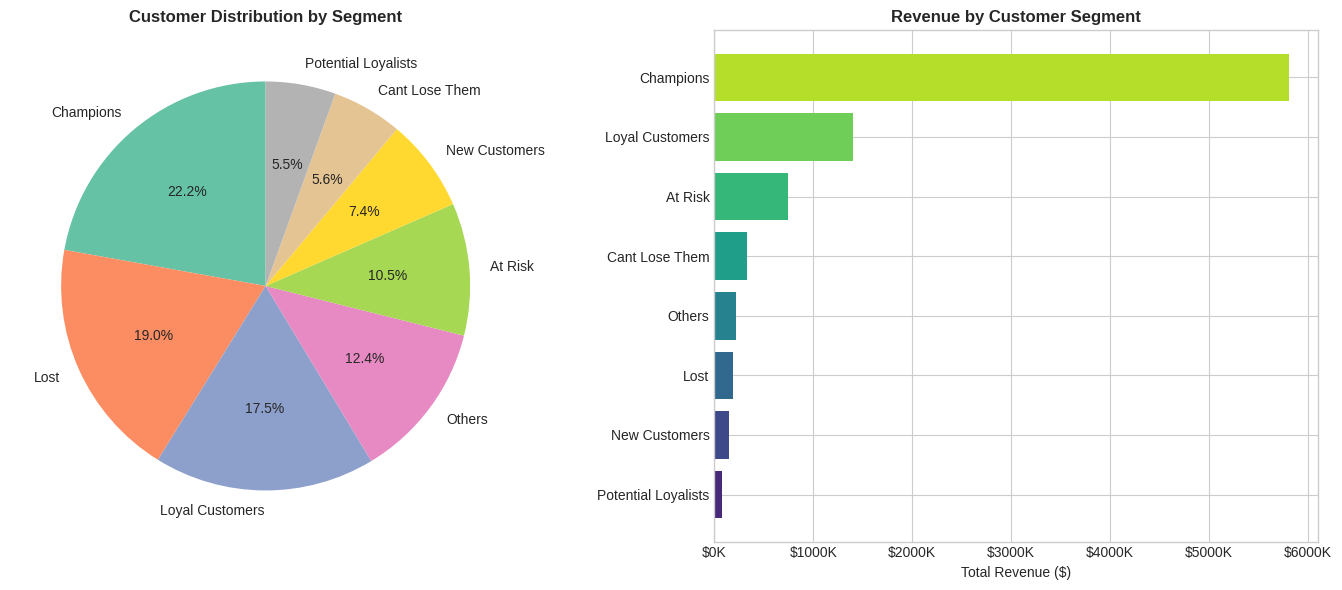


=== Key Insights ===
Champions: 22.2% of customers, 65.2% of revenue

Action Items:
- Champions: Reward program, early access to new products
- At Risk: Re-engagement campaign, special offers
- New Customers: Onboarding emails, first-purchase discount for next order


In [23]:
# Visualize Customer Segments
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Segment by Customer Count
segment_counts = rfm['Segment'].value_counts()
colors = sns.color_palette('Set2', len(segment_counts))
axes[0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[0].set_title('Customer Distribution by Segment', fontsize=12, fontweight='bold')

# Segment by Revenue
segment_revenue = rfm.groupby('Segment')['Monetary'].sum().sort_values(ascending=True)
axes[1].barh(segment_revenue.index, segment_revenue.values, color=sns.color_palette('viridis', len(segment_revenue)))
axes[1].set_title('Revenue by Customer Segment', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Total Revenue ($)')
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.savefig('customer_segments.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n=== Key Insights ===')
champions = segment_summary.loc['Champions'] if 'Champions' in segment_summary.index else None
if champions is not None:
    print(f"Champions: {champions['Pct_Customers']:.1f}% of customers, {champions['Pct_Revenue']:.1f}% of revenue")
print(f"\nAction Items:")
print("- Champions: Reward program, early access to new products")
print("- At Risk: Re-engagement campaign, special offers")
print("- New Customers: Onboarding emails, first-purchase discount for next order")

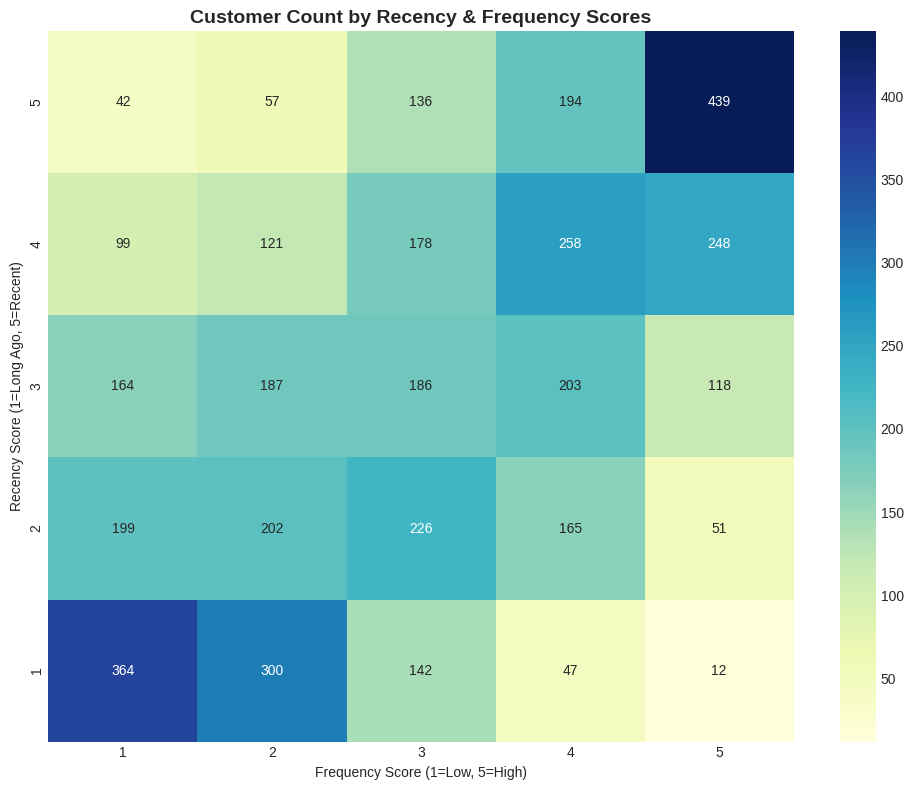

In [24]:
# RFM Heatmap
rfm_heatmap = rfm.groupby(['R_Score', 'F_Score']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(rfm_heatmap, annot=True, fmt='d', cmap='YlGnBu', ax=ax)
ax.set_title('Customer Count by Recency & Frequency Scores', fontsize=14, fontweight='bold')
ax.set_xlabel('Frequency Score (1=Low, 5=High)')
ax.set_ylabel('Recency Score (1=Long Ago, 5=Recent)')
plt.tight_layout()
plt.savefig('rfm_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. K-Means Clustering for Customer Segmentation

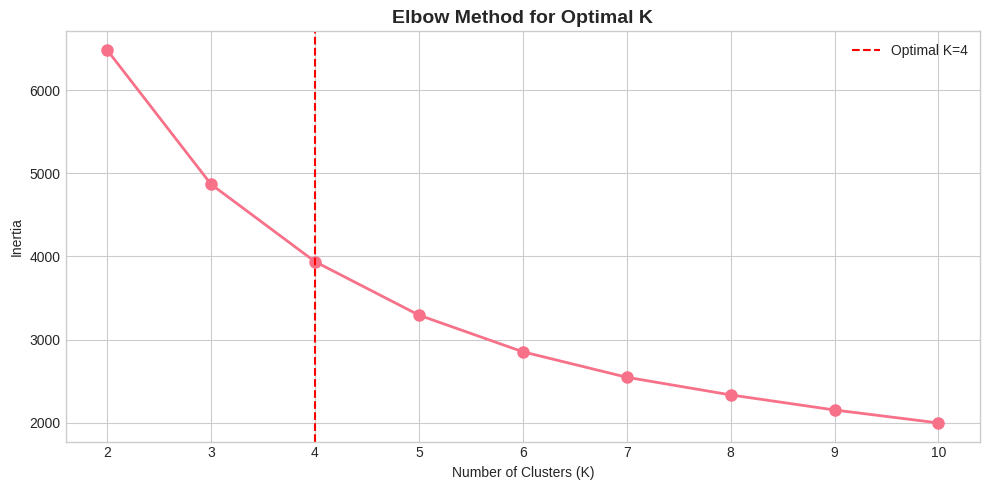

In [25]:
# Prepare data for clustering
rfm_clustering = rfm[['Recency', 'Frequency', 'Monetary']].copy()

# Log transform to handle skewness
rfm_clustering['Recency_log'] = np.log1p(rfm_clustering['Recency'])
rfm_clustering['Frequency_log'] = np.log1p(rfm_clustering['Frequency'])
rfm_clustering['Monetary_log'] = np.log1p(rfm_clustering['Monetary'])

# Standardize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering[['Recency_log', 'Frequency_log', 'Monetary_log']])

# Find optimal K using Elbow Method
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)

# Plot Elbow Curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
ax.set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Clusters (K)')
ax.set_ylabel('Inertia')
ax.axvline(x=4, color='r', linestyle='--', label='Optimal K=4')
ax.legend()
plt.tight_layout()
plt.savefig('elbow_curve.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
# Apply K-Means with K=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Cluster summary
cluster_summary = rfm.groupby('Cluster').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum']
}).round(2)

cluster_summary.columns = ['Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue']

# Name clusters based on characteristics
cluster_names = {
    cluster_summary['Avg_Monetary'].idxmax(): 'High Value',
    cluster_summary['Avg_Recency'].idxmax(): 'Churned',
    cluster_summary['Avg_Frequency'].idxmax(): 'Frequent Buyers',
}
# Assign remaining cluster
for i in range(4):
    if i not in cluster_names:
        cluster_names[i] = 'Regular'
        break

rfm['Cluster_Name'] = rfm['Cluster'].map(cluster_names)

print('=== K-Means Cluster Summary ===')
cluster_summary

=== K-Means Cluster Summary ===


,Count,Avg_Recency,Avg_Frequency,Avg_Monetary,Total_Revenue
Cluster,,,,,
0,837,18.12,2.15,551.82,461872.95
1,716,12.13,13.71,8074.27,5781175.08
2,1173,71.08,4.08,1802.83,2114718.42
3,1612,182.50,1.32,343.45,553641.45


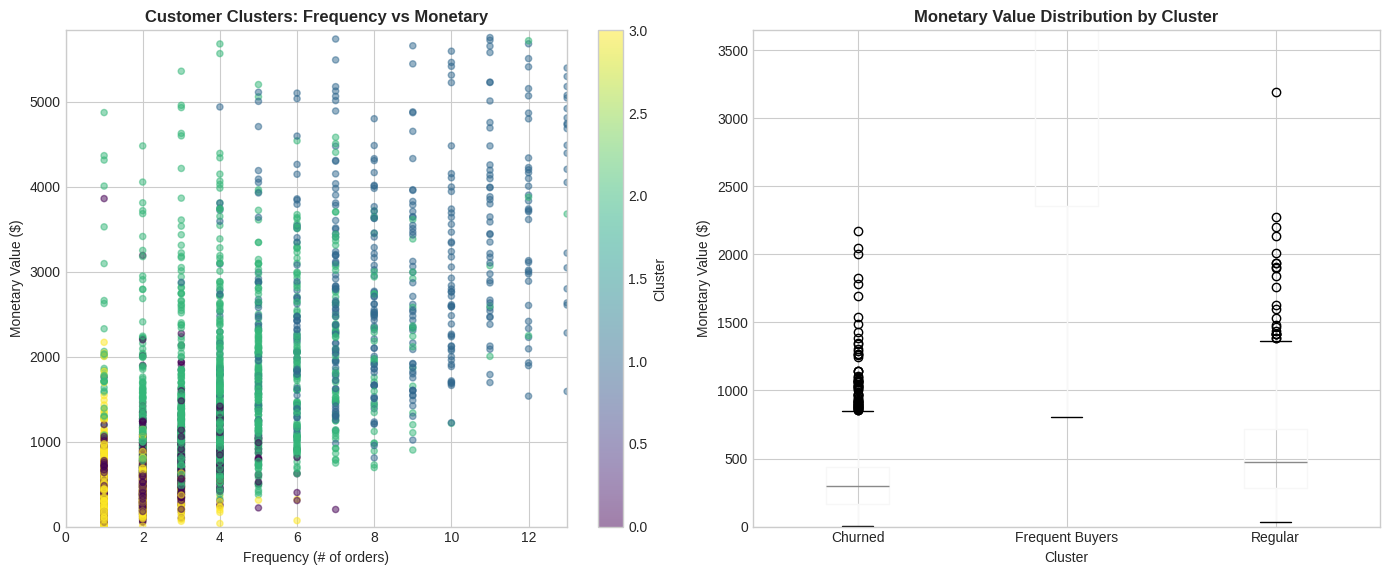

In [27]:
# Visualize Clusters
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot: Frequency vs Monetary
scatter = axes[0].scatter(rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'],
                          cmap='viridis', alpha=0.5, s=20)
axes[0].set_title('Customer Clusters: Frequency vs Monetary', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Frequency (# of orders)')
axes[0].set_ylabel('Monetary Value ($)')
axes[0].set_xlim(0, rfm['Frequency'].quantile(0.95))
axes[0].set_ylim(0, rfm['Monetary'].quantile(0.95))
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Box plot: Monetary by Cluster
rfm.boxplot(column='Monetary', by='Cluster_Name', ax=axes[1])
axes[1].set_title('Monetary Value Distribution by Cluster', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Monetary Value ($)')
axes[1].set_ylim(0, rfm['Monetary'].quantile(0.90))
plt.suptitle('')

plt.tight_layout()
plt.savefig('kmeans_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Time Series Forecasting (Monthly Revenue)

In [28]:
# Prepare monthly revenue data
monthly_data = data.groupby(data['InvoiceDate'].dt.to_period('M'))['Revenue'].sum().reset_index()
monthly_data.columns = ['Month', 'Revenue']
monthly_data['Month'] = monthly_data['Month'].dt.to_timestamp()
monthly_data = monthly_data.set_index('Month')

print('Monthly Revenue Data:')
monthly_data

Monthly Revenue Data:


,Revenue
Month,
2010-12-01,572713.89
2011-01-01,569445.04
2011-02-01,447137.35
2011-03-01,595500.76
2011-04-01,469200.36
2011-05-01,678594.56
2011-06-01,661213.69
2011-07-01,600091.01
2011-08-01,645343.90


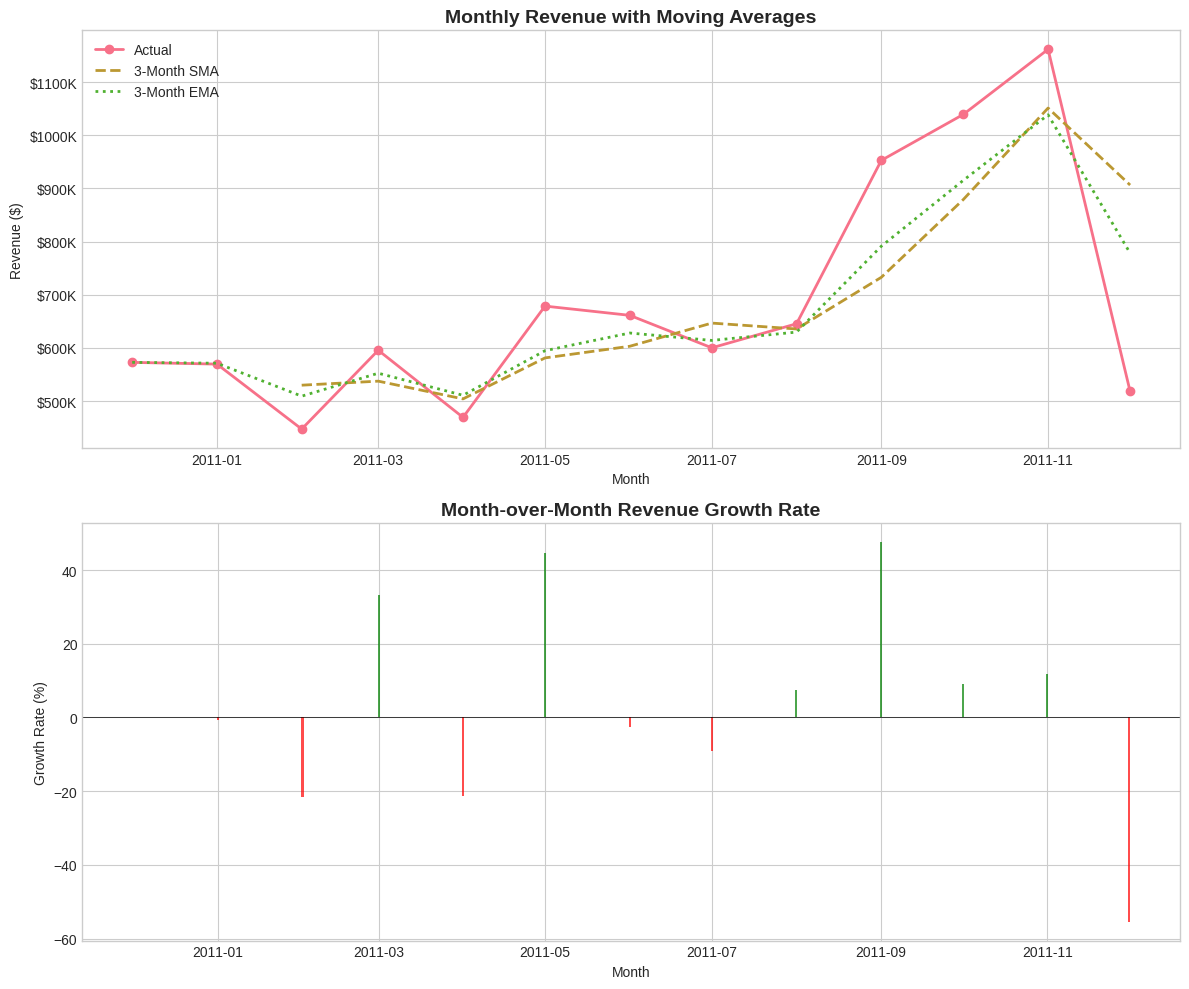


=== Forecast Insights ===
Average Monthly Revenue: $685,492.92
Average Growth Rate: 3.6%
November shows strong seasonal spike - prepare inventory accordingly


In [29]:
# Simple Moving Average Forecast
monthly_data['SMA_3'] = monthly_data['Revenue'].rolling(window=3).mean()

# Exponential Moving Average
monthly_data['EMA_3'] = monthly_data['Revenue'].ewm(span=3, adjust=False).mean()

# Calculate growth rate
monthly_data['Growth_Rate'] = monthly_data['Revenue'].pct_change() * 100

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Revenue with forecasts
axes[0].plot(monthly_data.index, monthly_data['Revenue'], marker='o', label='Actual', linewidth=2)
axes[0].plot(monthly_data.index, monthly_data['SMA_3'], label='3-Month SMA', linestyle='--', linewidth=2)
axes[0].plot(monthly_data.index, monthly_data['EMA_3'], label='3-Month EMA', linestyle=':', linewidth=2)
axes[0].set_title('Monthly Revenue with Moving Averages', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Revenue ($)')
axes[0].legend()
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Growth rate
colors = ['green' if x > 0 else 'red' for x in monthly_data['Growth_Rate'].fillna(0)]
axes[1].bar(monthly_data.index, monthly_data['Growth_Rate'].fillna(0), color=colors, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_title('Month-over-Month Revenue Growth Rate', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Growth Rate (%)')

plt.tight_layout()
plt.savefig('c', dpi=150, bbox_inches='tight')
plt.show()

print('\n=== Forecast Insights ===')
print(f"Average Monthly Revenue: ${monthly_data['Revenue'].mean():,.2f}")
print(f"Average Growth Rate: {monthly_data['Growth_Rate'].mean():.1f}%")
print(f"November shows strong seasonal spike - prepare inventory accordingly")

## 7. Key Findings & Recommendations

In [30]:
# Summary Dashboard
print('='*60)
print('         E-COMMERCE ANALYTICS SUMMARY REPORT')
print('='*60)

print('\n📊 BUSINESS METRICS')
print('-'*40)
print(f"Total Revenue:          ${data['Revenue'].sum():>15,.2f}")
print(f"Total Transactions:     {data['InvoiceNo'].nunique():>15,}")
print(f"Total Customers:        {data['CustomerID'].nunique():>15,}")
print(f"Total Products:         {data['StockCode'].nunique():>15,}")
print(f"Avg Order Value:        ${data.groupby('InvoiceNo')['Revenue'].sum().mean():>15,.2f}")
print(f"Avg Customer LTV:       ${rfm['Monetary'].mean():>15,.2f}")

print('\n👥 CUSTOMER SEGMENTS')
print('-'*40)
for segment in ['Champions', 'Loyal Customers', 'At Risk', 'Lost']:
    if segment in segment_summary.index:
        row = segment_summary.loc[segment]
        print(f"{segment:20s}: {row['Count']:>5.0f} customers ({row['Pct_Revenue']:.1f}% of revenue)")

print('\n📈 KEY INSIGHTS')
print('-'*40)
print('1. Peak sales month: November (holiday season)')
print('2. Best sales days: Tuesday-Thursday')
print('3. Peak hours: 10 AM - 3 PM')
print(f'4. UK dominates revenue ({uk_pct:.1f}%), Germany & France lead international')
print('5. Champions segment drives disproportionate revenue')

print('\n💡 RECOMMENDATIONS')
print('-'*40)
print('1. Launch re-engagement campaign for "At Risk" customers')
print('2. Create VIP rewards program for Champions')
print('3. Increase inventory before November peak')
print('4. Schedule marketing emails for 10 AM - 12 PM')
print('5. Expand marketing in Germany, France, Netherlands')
print('6. Consider weekend promotions (currently low Saturday sales)')

print('\n' + '='*60)

         E-COMMERCE ANALYTICS SUMMARY REPORT

📊 BUSINESS METRICS
----------------------------------------
Total Revenue:          $   8,911,407.90
Total Transactions:              18,532
Total Customers:                  4,338
Total Products:                   3,665
Avg Order Value:        $         480.87
Avg Customer LTV:       $       2,054.27

👥 CUSTOMER SEGMENTS
----------------------------------------
Champions           :   962 customers (65.2% of revenue)
Loyal Customers     :   758 customers (15.7% of revenue)
At Risk             :   454 customers (8.3% of revenue)
Lost                :   824 customers (2.1% of revenue)

📈 KEY INSIGHTS
----------------------------------------
1. Peak sales month: November (holiday season)
2. Best sales days: Tuesday-Thursday
3. Peak hours: 10 AM - 3 PM
4. UK dominates revenue (82.0%), Germany & France lead international
5. Champions segment drives disproportionate revenue

💡 RECOMMENDATIONS
----------------------------------------
1. Launch re

In [31]:
# Export customer segments for CRM
rfm_export = rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Segment', 'Cluster_Name']]
rfm_export.to_csv('customer_segments.csv', index=False)
print('Customer segments exported to: customer_segments.csv')

# Export monthly summary for dashboard
monthly_data.to_csv('monthly_revenue.csv')
print('Monthly revenue data exported to: monthly_revenue.csv')

Customer segments exported to: customer_segments.csv
Monthly revenue data exported to: monthly_revenue.csv


---

## Project Summary

This analysis provided actionable insights for an e-commerce business:

**Technical Skills Demonstrated:**
- Data cleaning and preprocessing (Pandas)
- Exploratory data analysis and visualization (Matplotlib, Seaborn)
- Customer segmentation using RFM analysis
- Machine learning clustering (K-Means)
- Time series analysis and forecasting
- Business insights and recommendations

**Business Value Delivered:**
- Identified high-value customer segments for targeted marketing
- Discovered revenue patterns for inventory optimization
- Provided actionable recommendations for customer retention

---

**Author:** Seun Alo  
**LinkedIn:** [linkedin.com/in/seunalo](https://linkedin.com/in/seunalo)  
**GitHub:** [github.com/seunalo](https://github.com/seunalo)